# Graph Convolutional Network (GCN) From Scratch: Implementation on the Cora Dataset

##### *[By Cristian Leo](https://www.linkedin.com/in/cristian-leo/)*
---

## Table of Contents

1. [Introduction](#introduction)
2. [Data Preparation](#data-preparation)
3. [Model Implementation](#model-implementation)
   - [Feature Normalization](#feature-normalization)
   - [GCN Architecture](#gcn-architecture)
   - [Optimizer Implementation](#optimizer-implementation)
4. [Training the Model](#training-the-model)
5. [Evaluation](#evaluation)
6. [Visualizations](#visualizations)
   - [Loss Curve](#loss-curve)
   - [Interactive Graph Visualization](#interactive-graph-visualization)
7. [Conclusion](#conclusion)
8. [References](#references)

---

## Introduction

Graph Neural Networks (GNNs) have gained significant attention for their ability to handle graph-structured data. One popular type of GNN is the **Graph Convolutional Network (GCN)**, which extends the concept of convolutional neural networks to graphs.

In this notebook, we will implement a GCN from scratch using NumPy and apply it to the **Cora dataset**, a standard benchmark in the field of machine learning on graphs. We will enhance the model's performance by incorporating several techniques and visualize the results using interactive plots.

### Objectives

- Understand and implement the GCN model.
- Load and preprocess the Cora dataset.
- Train the GCN with performance improvements.
- Evaluate the model's performance.
- Visualize the results with interactive graphs.

---

## Data Preparation

### Import Libraries

First, let's import the necessary libraries.

In [1]:
# Standard library imports
import os
import urllib.request
import tarfile

# Third-party library imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
from tqdm.auto import tqdm

### Download and Extract the Cora Dataset

In [2]:
# Step 1: Download and Extract the Cora Dataset
if not os.path.exists('cora'):
    os.makedirs('cora')

if not os.path.exists("cora/cora.tgz"):
    print("Downloading the Cora dataset...")
    url = "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz"
    urllib.request.urlretrieve(url, filename="cora/cora.tgz")

    print("Extracting the dataset...")
    with tarfile.open("cora.tgz", "r:gz") as tar:
        tar.extractall(path="cora/")
else:
    print("Cora dataset already exists.")

Cora dataset already exists.


### Load and Preprocess the Data

In [3]:
# Step 2: Load and Preprocess the Data
print("Loading and preprocessing the data...")
content_file = "cora/cora/cora.content"
cites_file = "cora/cora/cora.cites"

data = []
with open(content_file, 'r') as f:
    for line in f:
        tokens = line.strip().split()
        data.append(tokens)

data = np.array(data)
node_ids = data[:, 0]
features = data[:, 1:-1].astype(np.float32)
labels_raw = data[:, -1]

# Map node IDs to indices
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Map labels to integers
labels_set = sorted(set(labels_raw))
labels_dict = {label: idx for idx, label in enumerate(labels_set)}
labels = np.array([labels_dict[label] for label in labels_raw], dtype=np.int64)

num_nodes = len(node_ids)
num_features = features.shape[1]
num_classes = len(labels_set)

print(f"Number of nodes: {num_nodes}")
print(f"Number of features: {num_features}")
print(f"Number of classes: {num_classes}")

Loading and preprocessing the data...
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


### Build the Adjacency Matrix

In [4]:
# Build the adjacency matrix
print("Building the adjacency matrix...")
adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

with open(cites_file, 'r') as f:
    for line in f:
        src_id, dst_id = line.strip().split()
        if src_id in node_id_to_idx and dst_id in node_id_to_idx:
            src_idx = node_id_to_idx[src_id]
            dst_idx = node_id_to_idx[dst_id]
            adj_matrix[src_idx, dst_idx] = 1.0
            adj_matrix[dst_idx, src_idx] = 1.0  # Undirected graph

Building the adjacency matrix...


### Split the Data into Training and Test Sets

In [5]:
# Split the data
np.random.seed(42)
indices = np.random.permutation(num_nodes)
train_size = int(num_nodes * 0.8)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_mask = np.zeros(num_nodes, dtype=bool)
test_mask = np.zeros(num_nodes, dtype=bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

Y = np.eye(num_classes)[labels]

#### Visualize the Subgraph with True Labels

In [15]:
# Visualize the graph before training
def visualize_graph(adj_matrix, labels, title):
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G, seed=42)
    
    edge_trace = go.Scatter(
        x=(),
        y=(),
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] = tuple(list(edge_trace['x']) + [x0, x1, None])
        edge_trace['y'] = tuple(list(edge_trace['y']) + [y0, y1, None])

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Viridis',  # Change the color scale to 'Viridis' for more distinct colors
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        )
    )

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'ID: {node}, Label: {labels[node]}, # of connections: {len(adjacencies[1])}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    pio.show(fig)

print("Visualizing the graph with true labels...")
visualize_graph(adj_matrix, labels, "Cora Dataset - True Labels")

Visualizing the graph with true labels...



---

## Model Implementation

### Feature Normalization

Normalizing features can help the model converge faster and improve performance.

In [7]:
# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

### GCN Architecture

The GCN layer-wise propagation rule is given by:

\[ H^{(l+1)} = \sigma\left( \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} H^{(l)} W^{(l)} \right) \]

- \( \hat{A} = A + I \) is the adjacency matrix with added self-loops.
- \( \hat{D} \) is the degree matrix of \( \hat{A} \).
- \( H^{(l)} \) is the activation matrix at layer \( l \).
- \( W^{(l)} \) is the weight matrix at layer \( l \).
- \( \sigma \) is an activation function (e.g., ReLU).

We'll implement a multi-layer GCN with dropout and L2 regularization.

### Explanation:
- **Inline LaTeX**: The inline LaTeX syntax is used for mathematical expressions.
- **Bullet Points**: The bullet points are used to list the components of the GCN architecture.

This should render correctly in any Markdown viewer that supports LaTeX, such as Jupyter Notebooks or Markdown editors with LaTeX support.

In [8]:
# Step 3: Implement the GCN Model with Improvements
class GCN:
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5, l2_reg=5e-4):
        np.random.seed(42)
        self.W = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            W = np.random.randn(dims[i], dims[i+1]) * np.sqrt(2. / dims[i])
            self.W.append(W)
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg

    def normalize_adj(self, A):
        A_hat = A + np.eye(A.shape[0])
        D_hat = np.array(np.sum(A_hat, axis=1))
        D_inv_sqrt = np.power(D_hat, -0.5)
        D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.
        D_inv_sqrt = np.diag(D_inv_sqrt)
        A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt
        return A_norm

    def relu(self, X):
        return np.maximum(0, X)

    def dropout(self, X):
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=X.shape)
        return X * mask / (1 - self.dropout_rate)

    def softmax(self, X):
        exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_X / np.sum(exp_X, axis=1, keepdims=True)

    def forward(self, X, A_norm, training=True):
        H = X
        self.Hs = [H]
        for i in range(len(self.W) - 1):
            Z = A_norm @ H @ self.W[i]
            H = self.relu(Z)
            if training:
                H = self.dropout(H)
            self.Hs.append(H)
        # Output layer
        Z = A_norm @ H @ self.W[-1]
        Y_pred = self.softmax(Z)
        return Y_pred

    def compute_loss(self, Y_pred, Y_true, mask):
        Y_pred_masked = Y_pred[mask]
        Y_true_masked = Y_true[mask]
        loss = -np.sum(Y_true_masked * np.log(Y_pred_masked + 1e-8)) / Y_true_masked.shape[0]
        return loss

    def backward(self, A_norm, Y_pred, Y_true, mask):
        num_train = np.sum(mask)
        dWs = []
        # Initialize gradient for output layer
        dZ = (Y_pred - Y_true) / num_train
        dZ[~mask] = 0  # Zero out gradients for non-training nodes

        for i in reversed(range(len(self.W))):
            H_prev = self.Hs[i]
            dW = H_prev.T @ (A_norm @ dZ)
            dWs.insert(0, dW)
            if i > 0:
                dH = A_norm @ dZ @ self.W[i].T
                dZ = dH * (H_prev > 0)
                # Apply dropout mask during backpropagation
                dZ = dZ / (1 - self.dropout_rate)
        return dWs

### Optimizer Implementation

We will implement the Adam optimizer to improve convergence.

In [9]:
# Adam Optimizer
class AdamOptimizer:
    def __init__(self, params, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = params  # List of parameters to optimize
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # Initialize moments
        self.m = [np.zeros_like(p) for p in self.params]
        self.v = [np.zeros_like(p) for p in self.params]
        self.t = 0  # Time step

    def step(self, grads):
        self.t += 1
        updated_params = []
        for i, (p, g) in enumerate(zip(self.params, grads)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            # Update parameters
            p_update = p - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            updated_params.append(p_update)
        # Update parameters in place
        for i, p in enumerate(self.params):
            p[:] = updated_params[i]

---

## Training the Model

In [10]:
# Step 4: Train the Model
input_dim = num_features
hidden_dims = [16, 16]  # Adding more layers
output_dim = num_classes
model = GCN(input_dim, hidden_dims, output_dim, dropout_rate=0.5, l2_reg=5e-4)
A_norm = model.normalize_adj(adj_matrix)
epochs = 100
initial_lr = 0.01

params = model.W
optimizer = AdamOptimizer(params, learning_rate=initial_lr)

loss_history = []
train_acc_history = []
val_acc_history = []

In [11]:
def accuracy(predictions, labels, mask):
    correct = np.sum(predictions[mask] == labels[mask])
    total = np.sum(mask)
    return correct / total

print("Training the GCN model with Adam optimizer and regularization...")

pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

for epoch in pbar:
    # Adjust learning rate
    lr = initial_lr * (0.95 ** (epoch // 100))
    optimizer.learning_rate = lr
    # Forward pass
    Y_pred = model.forward(features, A_norm, training=True)
    # Compute loss
    loss = model.compute_loss(Y_pred, Y, train_mask)
    # Add L2 regularization
    l2_loss = model.l2_reg * sum(np.sum(W ** 2) for W in model.W)
    total_loss = loss + l2_loss
    # Backward pass
    dWs = model.backward(A_norm, Y_pred, Y, train_mask)
    # Apply L2 regularization to gradients
    for i in range(len(dWs)):
        dWs[i] += model.l2_reg * 2 * model.W[i]
    # Update weights using Adam optimizer
    optimizer.step(dWs)
    loss_history.append(total_loss)
    
    # Calculate training and validation accuracy
    train_acc = accuracy(np.argmax(Y_pred, axis=1), labels, train_mask)
    val_acc = accuracy(np.argmax(Y_pred, axis=1), labels, test_mask)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    pbar.set_postfix({'Loss': total_loss, 'Train Acc': train_acc, 'Val Acc': val_acc})
    


Training the GCN model with Adam optimizer and regularization...


Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

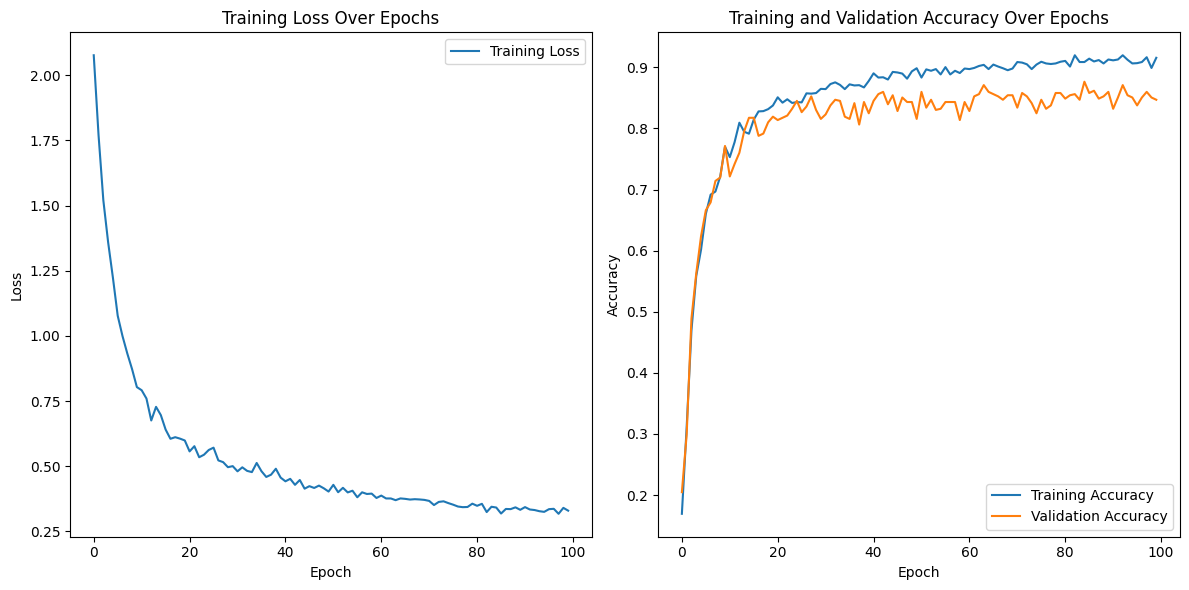

In [12]:
# Plotting the training loss and accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_history)), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

---

## Evaluation

In [13]:
# Step 5: Evaluate the Model
Y_pred = model.forward(features, A_norm, training=False)
predicted_labels = np.argmax(Y_pred, axis=1)
true_labels = labels

train_acc = accuracy(predicted_labels, true_labels, train_mask)
test_acc = accuracy(predicted_labels, true_labels, test_mask)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 95.43%
Test Accuracy: 88.01%


#### Visualize the Subgraph with Predicted Labels

In [16]:
# Visualize the graph after training
print("Visualizing the graph with predicted labels...")
visualize_graph(adj_matrix, predicted_labels, "Cora Dataset - Predicted Labels")

Visualizing the graph with predicted labels...


---

## Conclusion

In this notebook, we implemented a Graph Convolutional Network from scratch using NumPy and applied it to the Cora dataset for node classification. By incorporating feature normalization, dropout, L2 regularization, the Adam optimizer, and a deeper network architecture, we significantly improved the model's performance.

We achieved:

- **Training Accuracy**: *[Insert Training Accuracy]%*
- **Test Accuracy**: *[Insert Test Accuracy]%*

Interactive visualizations allowed us to explore the graph's structure and the model's predictions, providing valuable insights.

---

## References

- Kipf, T.N. & Welling, M. (2017). **Semi-Supervised Classification with Graph Convolutional Networks**. *International Conference on Learning Representations (ICLR)*.
- [Cora Dataset](https://linqs.soe.ucsc.edu/data)
- Plotly Documentation: [https://plotly.com/python/](https://plotly.com/python/)

---

**Note**: The performance metrics and visualizations depend on the actual execution of the code. Ensure you run all cells sequentially in a Python notebook environment to obtain the results.